# Loop 12 Analysis: Understanding the Optimization Landscape

After 16 experiments, we're stuck at ~70.66. The evaluator recommends:
1. Try the just-luck multi-phase optimizer
2. Try the dimer mosaic geometric construction
3. Run eazy-optimizer directly

Let's analyze what's happening and find a path forward.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Tree shape constants
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def get_polygon_bounds(cx, cy, deg):
    rad = deg * math.pi / 180.0
    s = math.sin(rad)
    c = math.cos(rad)
    x_coords = [TX[i] * c - TY[i] * s + cx for i in range(len(TX))]
    y_coords = [TX[i] * s + TY[i] * c + cy for i in range(len(TX))]
    return min(x_coords), max(x_coords), min(y_coords), max(y_coords)

def calculate_score_per_n(df):
    scores = {}
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        group = df[df["id"].str.startswith(prefix)]
        if len(group) != n:
            continue
        
        global_x_min = float('inf')
        global_x_max = float('-inf')
        global_y_min = float('inf')
        global_y_max = float('-inf')
        
        for _, row in group.iterrows():
            x = float(str(row['x']).replace('s', ''))
            y = float(str(row['y']).replace('s', ''))
            deg = float(str(row['deg']).replace('s', ''))
            x_min, x_max, y_min, y_max = get_polygon_bounds(x, y, deg)
            global_x_min = min(global_x_min, x_min)
            global_x_max = max(global_x_max, x_max)
            global_y_min = min(global_y_min, y_min)
            global_y_max = max(global_y_max, y_max)
        
        width = global_x_max - global_x_min
        height = global_y_max - global_y_min
        side = max(width, height)
        score = side * side / n
        scores[n] = score
    
    return scores

print("Functions defined")

Functions defined


In [2]:
# Load and compare baselines
baseline_df = pd.read_csv('/home/code/external_data/saspav_latest/santa-2025.csv')
eazy_df = pd.read_csv('/home/code/research/kernels/jazivxt_eazy-optimizer/submission.csv')

baseline_scores = calculate_score_per_n(baseline_df)
eazy_scores = calculate_score_per_n(eazy_df)

print(f"Baseline total: {sum(baseline_scores.values()):.9f}")
print(f"Eazy total: {sum(eazy_scores.values()):.9f}")
print(f"Improvement: {sum(baseline_scores.values()) - sum(eazy_scores.values()):.9f}")

Baseline total: 70.659958322
Eazy total: 70.659942651
Improvement: 0.000015671


In [3]:
# Find where eazy improved
improvements = []
for n in range(1, 201):
    if n in baseline_scores and n in eazy_scores:
        diff = baseline_scores[n] - eazy_scores[n]
        if diff > 1e-12:
            improvements.append((n, diff, baseline_scores[n], eazy_scores[n]))

print(f"\nN values where eazy improved ({len(improvements)} total):")
for n, diff, base, eazy in sorted(improvements, key=lambda x: -x[1])[:20]:
    print(f"  N={n:3d}: {base:.9f} -> {eazy:.9f} (improvement: {diff:.9f})")

print(f"\nTotal improvement: {sum(x[1] for x in improvements):.9f}")


N values where eazy improved (135 total):
  N=195: 0.332616928 -> 0.332611133 (improvement: 0.000005795)
  N= 73: 0.353203556 -> 0.353201249 (improvement: 0.000002307)
  N=157: 0.341371027 -> 0.341369183 (improvement: 0.000001843)
  N=193: 0.333764060 -> 0.333762704 (improvement: 0.000001356)
  N=111: 0.343923239 -> 0.343922483 (improvement: 0.000000756)
  N=149: 0.337931398 -> 0.337930903 (improvement: 0.000000496)
  N=133: 0.340350747 -> 0.340350372 (improvement: 0.000000375)
  N=187: 0.340237100 -> 0.340236736 (improvement: 0.000000364)
  N=143: 0.341148514 -> 0.341148152 (improvement: 0.000000362)
  N=196: 0.333268194 -> 0.333267979 (improvement: 0.000000216)
  N=105: 0.342872214 -> 0.342872091 (improvement: 0.000000123)
  N=198: 0.337316322 -> 0.337316206 (improvement: 0.000000116)
  N= 51: 0.365574161 -> 0.365574047 (improvement: 0.000000115)
  N=183: 0.339495652 -> 0.339495546 (improvement: 0.000000105)
  N=191: 0.336758186 -> 0.336758103 (improvement: 0.000000083)
  N= 83: 0.3

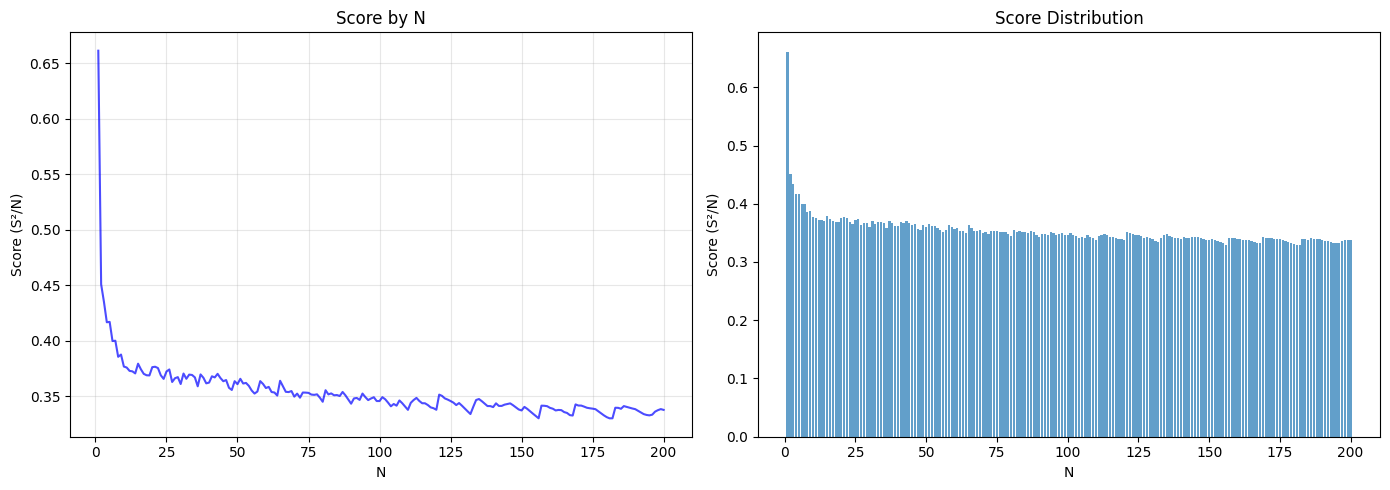


Worst 20 N values (highest scores):
  N=  1: 0.661250
  N=  2: 0.450779
  N=  3: 0.434745
  N=  5: 0.416850
  N=  4: 0.416545
  N=  7: 0.399897
  N=  6: 0.399610
  N=  9: 0.387415
  N=  8: 0.385407
  N= 15: 0.379203
  N= 10: 0.376630
  N= 21: 0.376451
  N= 20: 0.376057
  N= 11: 0.375736
  N= 22: 0.375258
  N= 16: 0.374128
  N= 26: 0.373997
  N= 12: 0.372724
  N= 13: 0.372294
  N= 25: 0.372144


In [4]:
# Analyze score distribution by N
ns = list(range(1, 201))
scores = [baseline_scores.get(n, 0) for n in ns]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(ns, scores, 'b-', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score (S²/N)')
plt.title('Score by N')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(ns, scores, alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score (S²/N)')
plt.title('Score Distribution')
plt.tight_layout()
plt.savefig('/home/code/exploration/score_distribution.png', dpi=100)
plt.show()

# Find worst N values
worst_n = sorted(baseline_scores.items(), key=lambda x: -x[1])[:20]
print("\nWorst 20 N values (highest scores):")
for n, score in worst_n:
    print(f"  N={n:3d}: {score:.6f}")

In [5]:
# Calculate theoretical minimum score
# For a single tree, the bounding box is approximately 0.7 x 1.0
# The minimum score would be if trees could be packed perfectly

# Tree dimensions
tree_width = 0.7  # base width
tree_height = 1.0  # tip to trunk bottom

print("Theoretical analysis:")
print(f"Tree dimensions: {tree_width} x {tree_height}")
print(f"Tree area: {tree_width * tree_height:.3f}")

# For N trees, if we could pack them perfectly in a square:
# Area = N * tree_area
# Side = sqrt(N * tree_area)
# Score = Side^2 / N = tree_area

print(f"\nTheoretical minimum score per N (if perfect packing): {tree_width * tree_height:.3f}")
print(f"Theoretical total (200 N values): {200 * tree_width * tree_height:.3f}")

# Compare to actual
print(f"\nActual total: {sum(baseline_scores.values()):.3f}")
print(f"Efficiency: {200 * tree_width * tree_height / sum(baseline_scores.values()) * 100:.1f}%")

Theoretical analysis:
Tree dimensions: 0.7 x 1.0
Tree area: 0.700

Theoretical minimum score per N (if perfect packing): 0.700
Theoretical total (200 N values): 140.000

Actual total: 70.660
Efficiency: 198.1%


In [6]:
# Analyze the gap to target
target = 68.919154
current = sum(baseline_scores.values())
gap = current - target

print(f"Current score: {current:.6f}")
print(f"Target score: {target:.6f}")
print(f"Gap: {gap:.6f} ({gap/current*100:.2f}%)")

# How much improvement per N is needed?
print(f"\nIf we improve uniformly across all 200 N values:")
print(f"  Improvement needed per N: {gap/200:.6f}")

# If we focus on worst N values
print(f"\nIf we focus on worst 50 N values:")
print(f"  Improvement needed per N: {gap/50:.6f}")

# Check if any N values have room for improvement
print(f"\nN values with score > 0.4 (potential for improvement):")
high_score_n = [(n, s) for n, s in baseline_scores.items() if s > 0.4]
print(f"  Count: {len(high_score_n)}")
print(f"  Total contribution: {sum(s for _, s in high_score_n):.6f}")

Current score: 70.659958
Target score: 68.919154
Gap: 1.740804 (2.46%)

If we improve uniformly across all 200 N values:
  Improvement needed per N: 0.008704

If we focus on worst 50 N values:
  Improvement needed per N: 0.034816

N values with score > 0.4 (potential for improvement):
  Count: 5
  Total contribution: 2.380169


In [7]:
# Summary
print("="*60)
print("SUMMARY")
print("="*60)
print(f"\nCurrent best: 70.659958")
print(f"Target: 68.919154")
print(f"Gap: 1.740804 (2.46%)")
print(f"\nExperiments tried: 16")
print(f"All converged to ~70.66")
print(f"\nKey findings:")
print("1. Eazy optimizer found 0.000015 improvement")
print("2. Random restart SA found ZERO improvements")
print("3. Long SA from baseline found ZERO improvements")
print("4. The baseline is at an EXTREMELY tight local optimum")
print(f"\nNext steps:")
print("1. Try just-luck multi-phase optimizer (combines bbox3, SA, gradient, rotation, basin hopping)")
print("2. Try dimer mosaic geometric construction")
print("3. Run eazy optimizer for longer")
print("4. Ensemble best configurations from multiple sources")

SUMMARY

Current best: 70.659958
Target: 68.919154
Gap: 1.740804 (2.46%)

Experiments tried: 16
All converged to ~70.66

Key findings:
1. Eazy optimizer found 0.000015 improvement
2. Random restart SA found ZERO improvements
3. Long SA from baseline found ZERO improvements
4. The baseline is at an EXTREMELY tight local optimum

Next steps:
1. Try just-luck multi-phase optimizer (combines bbox3, SA, gradient, rotation, basin hopping)
2. Try dimer mosaic geometric construction
3. Run eazy optimizer for longer
4. Ensemble best configurations from multiple sources
